In [1]:
# declare imports
import argparse
from datetime import datetime
from pathlib import Path
import os
import sys
import dask.dataframe as dd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

path_to_functions = os.path.abspath("../src")

# Add this folder to the system path
sys.path.append(path_to_functions)

from pearl.post_processing.bmi import (
    add_summary,
    calc_overall_risk,
    calc_percentage,
    calc_percentage_and_add_summary,
    calc_risk_by_group,
    clean_control,
    create_summary_table,
    group_order,
    group_order_with_sub_total,
    group_title_dict,
    palette,
    rearrange_group_order,
    round_thousand,
    calc_dm_prop,
    add_sub_total
)

start_time = datetime.now()
df_summary_dict = {}

# Define the argument parser

baseline_dir = Path('../out/S0_10/combined')
variable_dir = Path('../out/S3_10/combined')
out_dir = Path('../results')

start_year = 2013
end_year = 2017
font_size = 9

C:\Users\jackz\.conda\envs\PEARL\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


# Function

In [2]:
def calc_overall_bmi_risk(df: pd.DataFrame, years_follow_up: int = 7) -> pd.DataFrame:
    # filter for only overall group
    df_overall = df[df["group"] == "overall"]

    # filter for only follow_up-year follow up with dm
    df_overall_follow_up = df_overall.loc[
        (df_overall["years_after_h1yy"] > 0) & (df_overall["years_after_h1yy"] <= years_follow_up)
    ]

    # group by replication and age group and sum
    df_overall_follow_up_sum = (
        df_overall_follow_up.groupby(["init_bmi_group", "replication"])["n"].sum().reset_index()
    )
    df_overall_follow_up_sum = df_overall_follow_up_sum.rename(columns={"n": "dm_num"})

    # now for the denominator
    # First adjust people died in the same year of art initiation
    df_overall["time_exposure_to_risk"] = df_overall["time_exposure_to_risk"].where(
        df_overall["time_exposure_to_risk"] == 0, 1
    )

    # Second adjust people survive from simulation
    df_overall["time_exposure_to_risk"] = df_overall["time_exposure_to_risk"].where(
        df_overall["time_exposure_to_risk"] < 0, years_follow_up
    )

    # Third adjust people survived through follow-up period
    df_overall["time_exposure_to_risk"] = df_overall["time_exposure_to_risk"].where(
        df_overall["time_exposure_to_risk"] > years_follow_up, years_follow_up
    )

    # Calculate person-time variable
    df_overall["person-time-contributed"] = df_overall["n"] * df_overall["time_exposure_to_risk"]

    # group by replication and age group and sum
    df_overall_follow_up_sum_total = (
        df_overall.groupby(["init_bmi_group", "replication"])[["person-time-contributed", "n"]]
        .sum()
        .reset_index()
    )
    df_overall_follow_up_sum_total = df_overall_follow_up_sum_total.rename(columns={"n": "num"})

    # create risk table and calculate risk
    dm_risk_table = dd.merge(  # type: ignore [attr-defined]
        df_overall_follow_up_sum, df_overall_follow_up_sum_total, how="left"
    )
    dm_risk_table["risk"] = dm_risk_table["dm_num"] / dm_risk_table["person-time-contributed"]

    dm_risk_table["risk"] = dm_risk_table["risk"] * 1000

    return dm_risk_table

# Age Group

In [4]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "dm_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

dm_risk_table = calc_overall_risk(control_bmi_int_dm_prev).compute()

In [5]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(variable_dir / "dm_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_age_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

dm_risk_table_S1 = calc_overall_risk(control_bmi_int_dm_prev).compute()

In [6]:
S0_sample = (
        dm_risk_table.groupby("init_age_group")
        .apply(lambda x: x.sample(20, replace=True))
        .reset_index(drop=True)
    )

S1_sample = (
        dm_risk_table_S1.groupby("init_age_group")
        .apply(lambda x: x.sample(20, replace=True))
        .reset_index(drop=True)
    )

S0_sample = S0_sample.sort_values(by = 'init_age_group').reset_index(drop = True)
S1_sample = S1_sample.sort_values(by = 'init_age_group').reset_index(drop = True)

risk_df = S0_sample.copy()
risk_df['risk_S1'] =S1_sample['risk']

risk_df['abs_reduction'] = risk_df['risk'] - risk_df['risk_S1']
risk_df['rel_reduction'] = (risk_df['risk'] - risk_df['risk_S1'])/risk_df['risk'] * 100

C:\Users\jackz\AppData\Local\Temp\ipykernel_56072\2940801998.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(20, replace=True))
C:\Users\jackz\AppData\Local\Temp\ipykernel_56072\2940801998.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(20, replace=True))


In [7]:
risk_df = S0_sample.copy()
risk_df['risk_S1'] =S1_sample['risk']

risk_df['abs_reduction'] = risk_df['risk'] - risk_df['risk_S1']
risk_df['rel_reduction'] = (risk_df['risk'] - risk_df['risk_S1'])/risk_df['risk'] * 100

In [8]:
risk_df

init_age_group  replication  dm_num  person-time-contributed    num  \
0                 0            5     785                   115808  16544   
1                 0            2     752                   113428  16204   
2                 0            0     795                   114030  16290   
3                 0            2     752                   113428  16204   
4                 0            6     753                   113967  16281   
..              ...          ...     ...                      ...    ...   
135               6            3      15                      791    113   
136               6            8      16                      945    135   
137               6            5      17                      882    126   
138               6            6      22                      980    140   
139               6            5      17                      882    126   

          risk    risk_S1  abs_reduction  rel_reduction  
0     6.778461   5.317329       1.461132      21.555516  
1     6.629756   5.241434       1.388322      20.940773  
2     6.971850   6.021441       0.950409      13.632087  
3     6.629756   5.782106       0.847650      12.785544  
4     6.607176   5.782106       0.825070      12.487482  
..         ...        ...            ...            ...  
135  18.963338  13.906448       5.056890      26.666667  
136  16.931217  15.873016       1.058201       6.250000  
137  19.274376  17.006803       2.267574      11.764706  
138  22.448980  19.875776       2.573203      11.462451  
139  19.274376  17.006803       2.267574      11.764706  

[140 rows x 9 columns]

## Abs

C:\Users\jackz\AppData\Local\Temp\ipykernel_56072\571397031.py:3: UserWarning: The palette list has more values (16) than needed (7), which may not be intended.
  bar_ax = sns.boxplot(


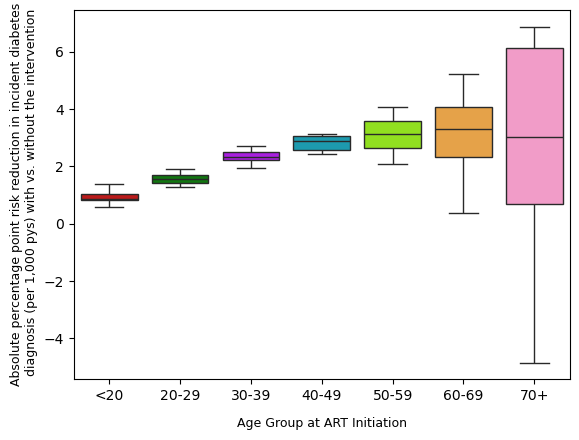

<Figure size 640x480 with 0 Axes>

In [11]:
# Age Abs Reduction
##########################################################################################
bar_ax = sns.boxplot(
    x=risk_df["init_age_group"],
    y=risk_df["abs_reduction"],
    palette=palette,
    whis = (2.5,97.5),
    showfliers=False,
    hue=risk_df["init_age_group"],
)

bar_ax.set_ylabel(
    "Absolute percentage point risk reduction in incident diabetes\n diagnosis (per 1,000 pys) with vs. without the intervention",
    fontsize=font_size,
)
bar_ax.set_xlabel("Age Group at ART Initiation", fontsize = font_size, labelpad = 10)
bar_ax.set_xticks(range(0, 7))
bar_ax.set_xticklabels(["<20", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"])

bar_ax.get_legend().remove()
bar_fig = bar_ax.get_figure()
bar_fig.savefig(out_dir / "bmi_age_group_risk/age_group_abs_reduction.png", bbox_inches="tight", dpi=1000)
plt.show()
plt.clf()

df = (
    risk_df.groupby("init_age_group")[["abs_reduction"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "bmi_age_group_risk/age_group_abs_risk_reduction_table.csv")

## Rel

C:\Users\jackz\AppData\Local\Temp\ipykernel_56072\3808244147.py:3: UserWarning: The palette list has more values (16) than needed (7), which may not be intended.
  bar_ax = sns.boxplot(


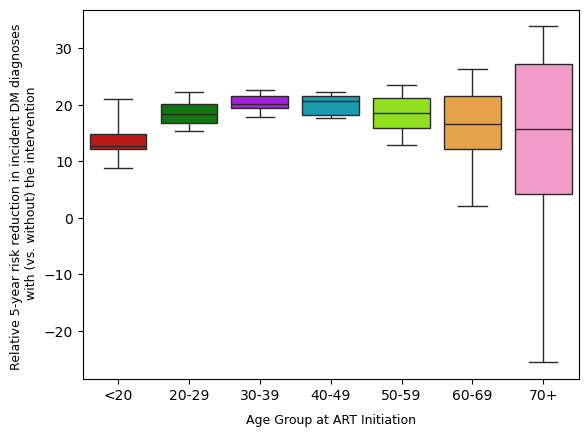

<Figure size 640x480 with 0 Axes>

In [13]:
# Age Rel Reduction
##########################################################################################
bar_ax = sns.boxplot(
    x=risk_df["init_age_group"],
    y=risk_df["rel_reduction"],
    palette=palette,
    whis = (2.5,97.5),
    showfliers=False,
    hue=risk_df["init_age_group"],
)
bar_ax.set_ylabel(
    "Relative 5-year risk reduction in incident DM diagnoses \n with (vs. without) the intervention",
    fontsize=font_size,
)
bar_ax.set_xlabel("Age Group at ART Initiation", fontsize = font_size, labelpad = 8)
bar_ax.set_xticks(range(0, 7))
bar_ax.set_xticklabels(["<20", "20-29", "30-39", "40-49", "50-59", "60-69", "70+"])

bar_ax.get_legend().remove()
bar_fig = bar_ax.get_figure()
bar_fig.savefig(out_dir / "bmi_age_group_risk/age_group_rel_reduction.png", bbox_inches="tight", dpi=1000)
plt.show()
plt.clf()

df = (
    risk_df.groupby("init_age_group")[["rel_reduction"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]", axis=1
)
df = rearrange_group_order(df)
df.to_csv(out_dir / "bmi_age_group_risk/age_group_rel_risk_reduction_table.csv")

# BMI Group

In [ ]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(baseline_dir / "bmi_cat_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_bmi_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

dm_risk_table = calc_overall_bmi_risk(control_bmi_int_dm_prev).compute()

In [ ]:
##################################################################################################################################
# we will look at the "bmi_int_dm_prev.h5" for S0
bmi_int_dm_prev = dd.read_parquet(variable_dir / "bmi_cat_final_output.parquet").reset_index()

# Add Overall
all_but_group = list(bmi_int_dm_prev.columns[1:])
bmi_int_dm_prev_overall = bmi_int_dm_prev.groupby(all_but_group).sum().reset_index()
bmi_int_dm_prev_overall["group"] = "overall"
bmi_int_dm_prev = dd.concat([bmi_int_dm_prev, bmi_int_dm_prev_overall], ignore_index=True)

# type the dataframe for space efficiency
bmi_int_dm_prev = bmi_int_dm_prev.astype(
    {
        "group": "str",
        "replication": "int16",
        "bmiInt_scenario": np.int8,
        "h1yy": np.int16,
        "init_bmi_group": np.int8,
        "bmiInt_impacted": bool,
        "dm": bool,
        "t_dm": np.int16,
        "n": np.int16,
    }
)

# clean to control specifications
control_bmi_int_dm_prev = clean_control(bmi_int_dm_prev, only_eligible=True, only_received = True)

# Figure 2A
dm_risk_table_S1 = calc_overall_bmi_risk(control_bmi_int_dm_prev).compute()

In [ ]:
S0_sample = (
        dm_risk_table.groupby("init_bmi_group")
        .apply(lambda x: x.sample(20, replace=True))
        .reset_index(drop=True)
    )

S1_sample = (
        dm_risk_table_S1.groupby("init_bmi_group")
        .apply(lambda x: x.sample(20, replace=True))
        .reset_index(drop=True)
    )

S0_sample = S0_sample.sort_values(by = 'init_bmi_group').reset_index(drop = True)
S1_sample = S1_sample.sort_values(by = 'init_bmi_group').reset_index(drop = True)

risk_df = S0_sample.copy()
risk_df['risk_S1'] =S1_sample['risk']

risk_df['abs_reduction'] = risk_df['risk'] - risk_df['risk_S1']
risk_df['rel_reduction'] = (risk_df['risk'] - risk_df['risk_S1'])/risk_df['risk'] * 100

In [ ]:
pre_art_bmi_bins = [0, 18.5, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, float("inf")]
# Create a label map
bmi_group_map = {i: f"[{pre_art_bmi_bins[i]}-{pre_art_bmi_bins[i+1]})" for i in range(len(pre_art_bmi_bins) - 1)}
bmi_group_map[12] = '> 30'
group_order = list(bmi_group_map.values())

risk_df["init_bmi_group"] = risk_df["init_bmi_group"].map(bmi_group_map)

## Abs

In [ ]:
# BMI Group Abs Reduction
#########################################################################################################################
bar_ax = sns.boxplot(
    x=risk_df["init_bmi_group"],
    y=risk_df["abs_reduction"],
    palette=palette,
    whis = (2.5,97.5),
    showfliers=False,
    hue=risk_df["init_bmi_group"],
    order = group_order[1:-1],
    )
bar_ax.set_ylabel(
    "Absolute percentage point risk reduction in incident diabetes\n diagnosis (per 1,000 pys) with vs. without the intervention",
    fontsize=font_size,
)
bar_ax.set_xlabel("BMI Group at ART Initiation", fontsize = font_size)
bar_ax.tick_params(axis="x", rotation=90)
bar_fig = bar_ax.get_figure()
bar_fig.savefig(out_dir / "bmi_age_group_risk/bmi_group_abs_reduction.png", bbox_inches="tight", dpi=1000)
plt.show()
plt.clf()

df = (
    risk_df.groupby("init_bmi_group")[["abs_reduction"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]", axis=1
)

df.to_csv(out_dir / "bmi_age_group_risk/bmi_group_abs_risk_reduction_table.csv")

## Rel

In [ ]:
# BMI Group Rel Reduction
#########################################################################################################################
bar_ax = sns.boxplot(
        x=risk_df["init_bmi_group"],
        y=risk_df["rel_reduction"],
        palette=palette,
        whis = (2.5,97.5),
        showfliers=False,
        hue=risk_df["init_bmi_group"],
        order = group_order[1:-1],
    )
bar_ax.set_ylabel(
    "Relative 5-year risk reduction in incident DM diagnoses \n with (vs. without) the intervention",
    fontsize=font_size,
)
bar_ax.set_xlabel("BMI Group at ART Initiation", fontsize = font_size)
bar_ax.tick_params(axis="x", rotation=90)
bar_fig = bar_ax.get_figure()
bar_fig.savefig(out_dir / "bmi_age_group_risk/bmi_group_rel_reduction.png", bbox_inches="tight", dpi=1000)
plt.show()
plt.clf()

df = (
    risk_df.groupby("init_bmi_group")[["rel_reduction"]]
    .quantile([0.025, 0.5, 0.975])
    .unstack()
    .reset_index()
)
df.columns = ["group", 0.025, 0.5, 0.975]
df["formatted"] = df.apply(
    lambda row: f"{row[0.50]:.1f} [{row[0.025]:.1f} - {row[0.975]:.1f}]", axis=1
)

# to save output
df.to_csv(out_dir / "bmi_age_group_risk/bmi_group_rel_risk_reduction_table.csv")